In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Set plot style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
def load_and_prepare_data(ticker, lookback=3):
    """
    Loads historical stock data, splits it into training/testing sets,
    and prepares it for LSTM models by scaling and creating time-series sequences.

    The split is 75% for training and 25% for testing, as per the paper's
    7.5-year training vs. 2.5-year testing period.
    """
    # Load data from yfinance for the specified 10-year range
    data = yf.download(ticker, start='2011-01-01', end='2021-01-01')
    close_prices = data['Close'].values.reshape(-1, 1)

    # Scale data to a range of [0, 1] for the neural networks
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(close_prices)

    # Create 3D time-series dataset with the specified lookback
    X, y = [], []
    for i in range(lookback, len(scaled_prices)):
        X.append(scaled_prices[i-lookback:i, 0])
        y.append(scaled_prices[i, 0])
    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time_steps, features] for LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data into training and testing sets
    split_index = int(len(X) * 0.75)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return data, X_train, X_test, y_train, y_test, scaler, split_index, lookback


In [3]:
# 2.1. Kalman Filter
def kalman_filter_predict(data):
    """
    Applies a linear Kalman Filter to predict stock prices based on a random walk model.
    The measurement uncertainty (R) is dynamically calculated from the variance of the
    previous three days' prices, as described in the paper.
    """
    prices = data['Close'].values

    # Initialize state, uncertainty, and noise parameters
    x_hat = prices[0]  # Initial state estimate (first day's price)
    P = 1.0            # Initial estimate uncertainty
    Q = 1e-5           # Process noise (assumes a near-random walk)

    predictions = []

    for i in range(len(prices)):
        # Calculate measurement noise (R) from local variance
        if i < 3:
            R = np.var(prices[:i+1])
        else:
            R = np.var(prices[i-3:i])
        if R == 0: R = 0.1 # Avoid division by zero

        # Measurement update (correction step)
        K = P / (P + R)  # Kalman Gain
        x_hat = x_hat + K * (prices[i] - x_hat)
        P = (1 - K) * P

        # Prediction for the *next* day is the current updated state
        predictions.append(x_hat)

        # Time update (prediction step for the next iteration)
        P = P + Q

    return np.array(predictions)

# 2.2. LSTM Model Architectures
def build_single_lstm(lookback=3):
    model = Sequential([
        LSTM(64, input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_dual_lstm(lookback=3):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_bidirectional_lstm(lookback=3):
    model = Sequential([
        Bidirectional(LSTM(64, input_shape=(lookback, 1))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_cnn_lstm(lookback=3):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [6]:
def evaluate_model(predictions, actual, model_name, ticker):
    """Calculates and returns a dictionary of performance metrics."""
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print(f'Results for {model_name} on {ticker}:')
    print(f'  RMSE: {rmse:.2f}')
    print(f'  MAE: {mae:.2f}')
    print(f'  R-squared: {r2:.2f}\n')

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def plot_predictions(data, predictions, split_idx, lookback, model_name, ticker):
    """Plots the original, training, and predicted prices."""
    plt.figure(figsize=(15, 7))

    # Original full dataset
    plt.plot(data.index, data['Close'], color='black', label='Original Dataset', alpha=0.3)

    # Training data
    train_idx = data.index[lookback : split_idx + lookback]
    plt.plot(train_idx, data['Close'].iloc[lookback : split_idx + lookback], color='red', label='Training Set')

    # Predicted/Test data
    test_idx = data.index[split_idx + lookback:]
    plt.plot(test_idx, predictions, color='blue', label='Predicted Price / Test Set')

    plt.title(f'{model_name} Prediction for {ticker} Stock', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{ticker} Stock Price ($)', fontsize=12)
    plt.legend()
    plt.show()

Starting Experiment for: TSLA


/tmp/ipython-input-2626585063.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2011-01-01', end='2021-01-01')
[*********************100%***********************]  1 of 1 completed


Results for Kalman Filter on TSLA:
  RMSE: 45.79
  MAE: 24.62
  R-squared: 0.23



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training Single Layer LSTM for TSLA ---
Results for Single Layer LSTM on TSLA:
  RMSE: 4.66
  MAE: 2.41
  R-squared: 0.99

--- Training Dual Layer LSTM for TSLA ---
Results for Dual Layer LSTM on TSLA:
  RMSE: 5.14
  MAE: 2.57
  R-squared: 0.99

--- Training Bidirectional LSTM for TSLA ---
Results for Bidirectional LSTM on TSLA:
  RMSE: 4.52
  MAE: 2.32
  R-squared: 0.99

--- Training CNN-LSTM for TSLA ---
Results for CNN-LSTM on TSLA:
  RMSE: 14.81
  MAE: 7.59
  R-squared: 0.92



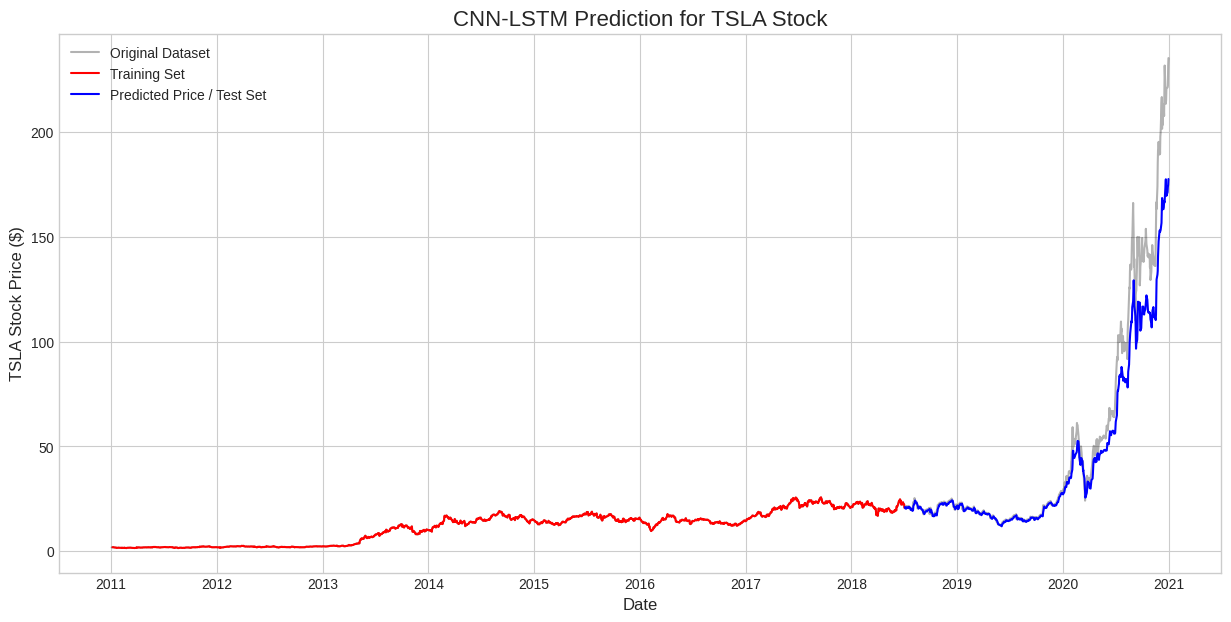


--- Comparative Results for TSLA ---
             Model      RMSE       MAE       R2
     Kalman Filter 45.791241 24.621817 0.229420
 Single Layer LSTM  4.663456  2.413495 0.992008
   Dual Layer LSTM  5.143242  2.572730 0.990279
Bidirectional LSTM  4.516332  2.324517 0.992504
          CNN-LSTM 14.808870  7.594953 0.919407
------------------------------------------------------

Starting Experiment for: MSFT


/tmp/ipython-input-2626585063.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2011-01-01', end='2021-01-01')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for Kalman Filter on MSFT:
  RMSE: 23.36
  MAE: 17.72
  R-squared: 0.64

--- Training Single Layer LSTM for MSFT ---
Results for Single Layer LSTM on MSFT:
  RMSE: 3.79
  MAE: 2.62
  R-squared: 0.99

--- Training Dual Layer LSTM for MSFT ---
Results for Dual Layer LSTM on MSFT:
  RMSE: 4.26
  MAE: 2.98
  R-squared: 0.99

--- Training Bidirectional LSTM for MSFT ---
Results for Bidirectional LSTM on MSFT:
  RMSE: 3.55
  MAE: 2.48
  R-squared: 0.99



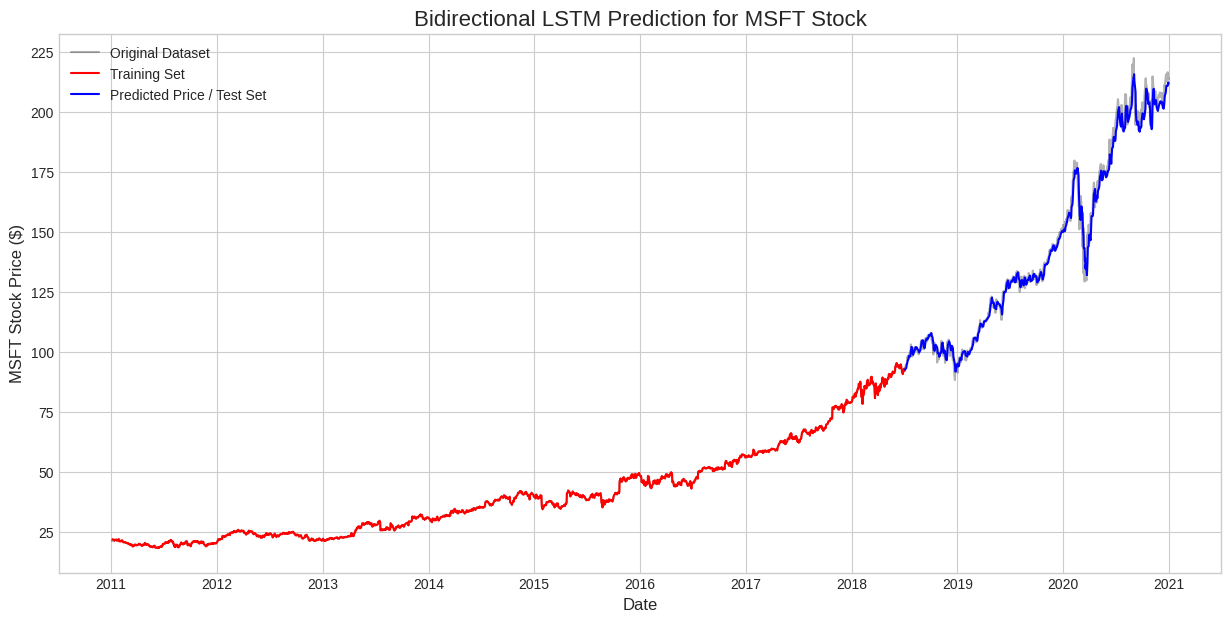

--- Training CNN-LSTM for MSFT ---
Results for CNN-LSTM on MSFT:
  RMSE: 5.76
  MAE: 4.55
  R-squared: 0.98


--- Comparative Results for MSFT ---
             Model      RMSE       MAE       R2
     Kalman Filter 23.358375 17.715930 0.636557
 Single Layer LSTM  3.791472  2.623300 0.990424
   Dual Layer LSTM  4.262540  2.980988 0.987897
Bidirectional LSTM  3.553939  2.482287 0.991587
          CNN-LSTM  5.762793  4.549566 0.977878
------------------------------------------------------



In [8]:
def run_experiment(ticker):
    """
    Main function to run the full experiment for a given stock ticker.
    """
    print(f"======================================================")
    print(f"Starting Experiment for: {ticker}")
    print(f"======================================================")

    results = []

    # Load and prepare data
    stock_data, X_train, X_test, y_train, y_test, scaler, split_idx, lookback = load_and_prepare_data(ticker)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # --- 4.1. Run Kalman Filter ---
    test_data_unscaled = stock_data.iloc[split_idx + lookback:]
    kf_preds_full = kalman_filter_predict(stock_data)
    kf_preds_test = kf_preds_full[split_idx + lookback:]
    results.append(evaluate_model(kf_preds_test, test_data_unscaled['Close'].values, 'Kalman Filter', ticker))

    # --- 4.2. Run LSTM Models ---
    models_to_run = {
        'Single Layer LSTM': build_single_lstm(),
        'Dual Layer LSTM': build_dual_lstm(),
        'Bidirectional LSTM': build_bidirectional_lstm(),
        'CNN-LSTM': build_cnn_lstm()
    }

    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0)

    for name, model in models_to_run.items():
        print(f'--- Training {name} for {ticker} ---')
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

        # Predict and inverse scale to original price range
        predictions_scaled = model.predict(X_test, verbose=0)
        predictions = scaler.inverse_transform(predictions_scaled)

        results.append(evaluate_model(predictions, actual_prices, name, ticker))

        # As per the paper, plot the "champion" models for each stock type
        if (ticker == 'TSLA' and name == 'CNN-LSTM') or \
           (ticker == 'MSFT' and name == 'Bidirectional LSTM'):
            plot_predictions(stock_data, predictions, split_idx, lookback, name, ticker)

    # Display final results in a clean table
    df_results = pd.DataFrame(results)
    print(f"\n--- Comparative Results for {ticker} ---")
    print(df_results.to_string(index=False))
    print(f"------------------------------------------------------\n")


# Run experiments for both high-volatility (TSLA) and low-volatility (MSFT) stocks
if __name__ == '__main__':
    run_experiment('TSLA')
    run_experiment('MSFT')
